In [1]:
import sys
import numpy as np
import pandas as pd
import scipy as sc
from scipy.stats import mannwhitneyu, zscore, ttest_ind, ttest_ind_from_stats, \
                        f_oneway, wilcoxon, kruskal, friedmanchisquare
from statsmodels.stats import weightstats as stests
import matplotlib.pyplot as plt

sys.path.append("../")

from src.ab.helpers import min_sample_size_avg

%matplotlib inline

In [98]:
class NormalGenerator():
    def __init__(self,
                 mean,
                 std):
        self.mean = mean
        self.std = std
    def get_sample(self,
                   size):
        return np.random.normal(loc=self.mean, 
                                   scale=self.std, 
                                   size=size)
    
def calc_stats(mu,
               sd,
               start,
               step,
               num_steps,
               n_experiments):
    sizes=np.arange(0, num_steps)*step+start

    for size in sizes:
        generator = NormalGenerator(mean=mu,
                                    std=sd)
        #generate samples
        values = np.array([generator.get_sample(size=size) for i in range(n_experiments)])
        stats = np.array([np.array([i.mean(), i.std(), i.std(ddof=1)]) for i in values])
        res = stats[:, 0].mean(), stats[:, 1].mean(), stats[:, 2].mean(), 1-stats[:, 1].mean()/sd, 1-stats[:, 2].mean()/sd
        result_errors.append(res)

    result_errors_df = pd.DataFrame(result_errors, columns=['sample_mean',
                                                             'sample_sd',
                                                             'sample_sd_corrected',
                                                             'sample_sd_error',
                                                             'sample_sd_corrected_error'])
    result_errors_df['sample_size'] = sizes
    #calc MAPE
    MAPE_sd = np.mean(np.abs((sd - result_errors_df['sample_sd']) / sd)) * 100
    MAPE_sd_corrected = np.mean(np.abs((sd - result_errors_df['sample_sd_corrected']) / sd)) * 100
    print("MAPE without correction: {}, MAPE with correction: {}".format(MAPE_sd, MAPE_sd_corrected))
    return result_errors_df

### Small samples (<100)

In [99]:
%%time
mu, sd = 50, 100
n_experiments=1000
result_errors = list()
start = 10
step = 10
num = 10

result_errors_df_10_100 = calc_stats(mu=mu,
                                   sd=sd,
                                   start=start,
                                   step=step,
                                   num_steps=num,
                                   n_experiments=n_experiments)

MAPE without correction: 1.978784929330283, MAPE with correction: 0.5109764183445776
Wall time: 457 ms


### Average (>=100 and <1000)

In [109]:
%%time
n_experiments=1000
result_errors = list()
start = 150
step = 50
num = 18

result_errors_df_150_1000 = calc_stats(mu=mu,
                                   sd=sd,
                                   start=start,
                                   step=step,
                                   num_steps=num,
                                   n_experiments=n_experiments)

MAPE without correction: 0.17784566716660855, MAPE with correction: 0.07957115554670618
Wall time: 1.11 s


### Large samples (>1000)

In [114]:
%%time
n_experiments=1000
result_errors = list()
start = 1050
step = 100
num = 40

result_errors_df_1050_5000 = calc_stats(mu=mu,
                                   sd=sd,
                                   start=start,
                                   step=step,
                                   num_steps=num,
                                   n_experiments=n_experiments)

MAPE without correction: 0.04190362729917609, MAPE with correction: 0.0350725741879156
Wall time: 5.45 s


### Combine results

In [115]:
result_errors_df = pd.concat([result_errors_df_10_100,
                              result_errors_df_150_1000,
                              result_errors_df_1050_5000])

### Plot results

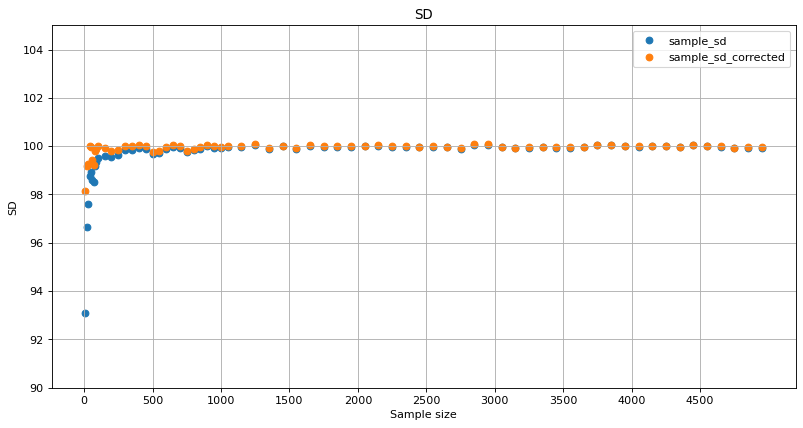

In [116]:
plt.figure(figsize=(12, 6), dpi=80)
plt.scatter(x=result_errors_df['sample_size'],
            y=result_errors_df['sample_sd'],
            label = "sample_sd")
plt.scatter(x=result_errors_df['sample_size'],
            y=result_errors_df['sample_sd_corrected'],
            label = "sample_sd_corrected")

plt.legend()
plt.title('SD')
plt.xlabel("Sample size")
plt.ylabel('SD')
plt.grid()
plt.xticks(np.arange(0, result_errors_df['sample_size'].max(), step=500))
plt.ylim(90, 105)
plt.show()

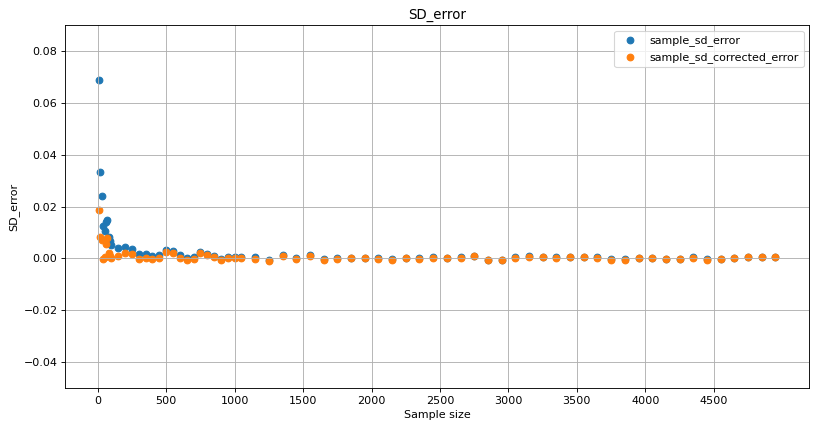

In [117]:
plt.figure(figsize=(12, 6), dpi=80)
plt.scatter(x=result_errors_df['sample_size'],
            y=result_errors_df['sample_sd_error'],
            label = "sample_sd_error")
plt.scatter(x=result_errors_df['sample_size'],
            y=result_errors_df['sample_sd_corrected_error'],
            label = "sample_sd_corrected_error")

plt.legend()
plt.title('SD_error')
plt.xlabel("Sample size")
plt.ylabel('SD_error')
plt.grid()
plt.xticks(np.arange(0, result_errors_df['sample_size'].max(), step=500))
plt.ylim(-0.05, 0.09)
plt.show()

### Sample mean

In [121]:
result_errors_df[result_errors_df['sample_size']<100]['sample_mean'].mean(), \
result_errors_df[result_errors_df['sample_size']>100]['sample_mean'].mean()

(50.02618694313362, 50.01922213663144)

### Выводы

Для относительно небольших выборок (до 100 наблюдений)

1. Среднее выборочных средних сходится к среднему генеральной совокупности
2. Среднее SD без поправки (домножения на n/(n-1)) дает смещенную оценку стандартного отклонения 
3. Домножение на n/(n-1) дает более точную оценку стандартного отклонения

Для выборок от 100 до 1000 ситуация похожая. 

В то же время, для больших выборок (более 10000 наблюдений) поправка уже не влияет так заметно на ошибку, хотя все равно ошибка меньше (в примере - MAPE)